# Using Regression Models to Determine which Factors Affect Laptop Prices
## 1. Introduction
With a vast array of laptops on the market, all with a different variation of specifications, features and price, it can become confusing what factors actually account for the price tag. This project aims to assess, one by one, each factor to discover it's relationship with it's retail price. To do so, this report will:

1. Use Multiple Regression Lines to predict the impact Quantative and Binary Categorical variables have on Price
2. Use alternative techniques to analyse other factors affecting Price

The data was taken from Kaggle (https://www.kaggle.com/datasets/ionaskel/laptop-prices) and includes the following column headings:

**Laptop_ID** <br>
**Company** - Name of Company<br>
**Product** - Name of Product<br>
**TypeName** - Type of Laptop<br>
**Inches** - Screen Size in Inches<br>
**ScreenResolution** - Details about the Screen Resolution whether it is Touchscreen or not<br>
**Cpu** - Information about CPU (Make, Type, Size)<br>
**Ram** - Size of RAM<br>
**Memory** - Information about the Memory<br>
**GPU** - Infomation on the GPU (Make, Type, Size)<br>
**OpSys** - The Operating System the laptop uses<br>
**Weight** - Laptop's Weight<br>
**Price_euros** - Laptop's retail price in Euros<br>

The dataset was read into Jupyter Notebook and the *Laptop_ID* and *Product* columns were dropped as they were unneeded.

A sample of the dataset can be viewed below.

In [1]:
import pandas as pd
import numpy as np
import re
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from re import search

#Read file into Jupyter Notebook, drop unneeded columns.

laptop = pd.read_csv('laptop_price.csv', encoding='latin-1')

laptop = laptop.drop(columns=['laptop_ID', 'Product'])

display(laptop.head())

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,HP,Ultrabook,12.5,4K Ultra HD / Touchscreen 3840x2160,Intel Core M 6Y75 1.2GHz,8GB,240GB SSD,Intel HD Graphics 515,Windows 10,1.09kg,3100.0
1,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.9GHz,16GB,512GB SSD,AMD Radeon Pro 560,macOS,1.83kg,2858.0
2,Toshiba,Ultrabook,13.3,Full HD / Touchscreen 1920x1080,Intel Core i7 7500U 2.7GHz,32GB,512GB SSD,Intel HD Graphics 620,Windows 10,1.05kg,2799.0
3,Dell,Ultrabook,13.3,Quad HD+ / Touchscreen 3200x1800,Intel Core i7 7500U 2.7GHz,16GB,512GB SSD,Intel HD Graphics 620,Windows 10,1.2kg,2680.0
4,Lenovo,Notebook,17.3,IPS Panel Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,8GB,256GB SSD,Nvidia Quadro M620M,Windows 10,3.4kg,2999.0


## 2. Data Tidying & Wrangling
The dataset is very useful and extensive, however, some columns contain several different types of data under one column heading. For example, the 'Cpu' column contains the brand, the type and the power of the CPU. In addition, some columns are quite detailed and contained unuseful extra infomation. Therefore, columns had to be split and tidied in order to only extract the useful information from them.

These changes included:
1. Changing column headings to more code-friendly names. <br>
<br>
2. Remove GB (gigabyte) and kg (kilogram) from the 'ram' and 'weight' columns and convert to an integer/float datatype.<br>
<br>
3. Extract only the CPU brand from the 'cpu' column and save to 'cpu_brand'<br>
4. Extract CPU Size(GHz) from 'cpu' column using Regex, save as float to new cpu_ghz column.<br>
<br>
5. Extract only the GPU Brand from the 'gpu' column.<br>
<br>
6. Extract Touchscreen Feature from 'screen_res' column and save under 'touchscreen' as either 'Y' or 'N'<br>
7. Extract Resolution using Regex from 'screen_res' column and save to new 'res' column<br>
<br>
8. Extract Memory Type (SSD, HDD, Hybrid, Flash) from 'memory' column and save under 'memory_type'<br>
9. Extract Memory Size from 'memory' column using Regex and converted to an integer,if the unit is in TB then value is multiplied by 1000.<br>
<br>
10. Laptop Price is rounded to nearest Euro and converted to integer<br>

Then unnecessary columns were dropped from the dataframe.

The final tidy and wrangled dataframe is shown below.

In [2]:
# 1. Change column names to be more coding-friendly.
laptop = laptop.set_axis(['company', 'type', 'size', 'screen_res',
                            'cpu', 'ram', 'memory', 'gpu', 'system',
                            'weight', 'price_eu'], axis=1, inplace=False)

# 2. Tidy data and convert datatypes.
laptop['ram'] = laptop.ram.str.replace('GB', '').astype(np.int64)
laptop['weight'] = laptop.weight.str.replace('kg', '').astype(float)
laptop['type'] = laptop.type.str.replace(' Convertible', '')

# Remove 'Gaming' and 'Workstation' types from dataset.
laptop = laptop[(laptop.type != 'Gaming')]
laptop = laptop[(laptop.type != 'Workstation')]

In [3]:
# 3. Extract CPU Brand from 'cpu' column.
cpu_list = laptop['cpu'].tolist()
cpu_brand_list = []
for x in cpu_list:
    if 'Intel' in x: 
        cpu_brand_list.append('Intel') 
    else:
        cpu_brand_list.append('AMD')
        
laptop['cpu_brand'] = cpu_brand_list


# 4. Extract CPU Size(GHz) from 'cpu' column using Regex, save as float to new column.
cpu_ghz_list = []
for i in cpu_list:
    match = re.search('\w*\\.?\w*GHz', i)
    if match:
        cpu_ghz_list.append(match.group())
        
laptop['cpu_ghz'] = cpu_ghz_list
laptop['cpu_ghz'] = laptop.cpu_ghz.str.replace('GHz', '')
laptop['cpu_ghz'] = laptop['cpu_ghz'].astype('float')


# 5. Extract GPU Brand, place in new column.
gpu_list = laptop['gpu'].tolist()
gpu_brand_list = []
for x in gpu_list:
    if 'Intel' in x: 
        gpu_brand_list.append('Intel') 
    elif 'AMD' in x: 
        gpu_brand_list.append('AMD') 
    else:
        gpu_brand_list.append('Nvidia')
        
laptop['gpu_brand'] = gpu_brand_list


# 6. Extract Touchscreen Feature from 'screen_res' column.
screen_res_list = laptop['screen_res'].tolist()
touch_list = []
for x in screen_res_list:
    if 'Touch' in x: 
        touch_list.append('Y') 
    else:
        touch_list.append('N')
        
laptop['touchscreen'] = touch_list


# 7. Extract Resolution using Regex from 'screen_res' column.
res_list = []
for i in screen_res_list:
    match = re.search('\d{3,5}\w\d{3,5}', i)

    if match:
        res_list.append(match.group())
laptop['res'] = res_list


# 8. Extract Memory Type from 'memory' column. 
memory_list = laptop['memory'].tolist()
memory_type_list = []
for x in memory_list:
    if 'HDD' in x and 'SSD' in x: 
        memory_type_list.append('Hybrid')
    elif 'Hybrid' in x: 
        memory_type_list.append('Hybrid')
    elif 'SSD' in x: 
        memory_type_list.append('SSD')
    elif 'HDD' in x: 
        memory_type_list.append('HDD')
    else:
        memory_type_list.append('Flash')
        
laptop['memory_type'] = memory_type_list


# 9. Extract Memory Size from 'memory' column using Regex and converted to an integer,
# if the unit is TB then value is multiplied by 1000.
memory_size_list = []
for i in memory_list:
    match = re.search('[^-\s]\d*\\.?\d*\w', i)
    if match:
        memory_size_list.append(match.group())
        
memory_int_list=[]
for i in memory_size_list:
    mem_int = i.replace('.0', '')
    if 'T' in i:
        integer = int(mem_int.replace('T', ''))
        final = integer * 1000
    else:
        integer = mem_int.replace('G','')
        final = int(integer)
    memory_int_list.append(final)
    
laptop['memory_size'] = memory_int_list


# 10. Laptop Price is rounded to nearest Euro 
laptop['price_eu'] = round(laptop.price_eu, 0).astype(np.int64)

# Unneeded columns then dropped.
laptop = laptop.drop(columns=['screen_res', 'cpu', 'gpu', 'memory'])

display(laptop.head())
print('The Final Tidied Dataframe')

,company,type,size,ram,system,weight,price_eu,cpu_brand,cpu_ghz,gpu_brand,touchscreen,res,memory_type,memory_size
0,HP,Ultrabook,12.5,8,Windows 10,1.09,3100,Intel,1.2,Intel,Y,3840x2160,SSD,240
1,Apple,Ultrabook,15.4,16,macOS,1.83,2858,Intel,2.9,AMD,N,2880x1800,SSD,512
2,Toshiba,Ultrabook,13.3,32,Windows 10,1.05,2799,Intel,2.7,Intel,Y,1920x1080,SSD,512
3,Dell,Ultrabook,13.3,16,Windows 10,1.20,2680,Intel,2.7,Intel,Y,3200x1800,SSD,512
4,Lenovo,Notebook,17.3,8,Windows 10,3.40,2999,Intel,2.8,Nvidia,N,1920x1080,SSD,256


The Final Tidied Dataframe


## 3. Inspect Data
The dataset was then inspected to see if the datatypes were in their correct form and that the data wrangling had been done successfully. The number of non-null values for each column were also documented and the number of NULL values in total were counted.

After observing the datatypes and the range of values, all values seemed reasonable and approriate which suggests the formating had been carried out correctly.

There are 1067 data values which gives us a good size sample to carry out regression models.

In [4]:
print(laptop.info())

laptop = laptop.sort_values('cpu_ghz', ascending=False)
display(laptop.describe())

null_value_count = laptop.isna().sum().sum()
print(f'There are {null_value_count} null values in the Laptop Dataset')
print(f'There are {len(laptop)} data values in total')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1067 entries, 0 to 1300
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   company      1067 non-null   object 
 1   type         1067 non-null   object 
 2   size         1067 non-null   float64
 3   ram          1067 non-null   int64  
 4   system       1067 non-null   object 
 5   weight       1067 non-null   float64
 6   price_eu     1067 non-null   int64  
 7   cpu_brand    1067 non-null   object 
 8   cpu_ghz      1067 non-null   float64
 9   gpu_brand    1067 non-null   object 
 10  touchscreen  1067 non-null   object 
 11  res          1067 non-null   object 
 12  memory_type  1067 non-null   object 
 13  memory_size  1067 non-null   int64  
dtypes: float64(3), int64(3), object(8)
memory usage: 125.0+ KB
None


,size,ram,weight,price_eu,cpu_ghz,memory_size
count,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000
mean,14.733833,7.214620,1.849409,971.094658,2.204030,457.818182
std,1.363264,3.606573,0.468052,558.297134,0.508983,366.811003
min,10.100000,2.000000,0.690000,174.000000,0.900000,16.000000
25%,14.000000,4.000000,1.425000,544.000000,1.800000,256.000000
50%,15.600000,8.000000,1.910000,839.000000,2.400000,256.000000
75%,15.600000,8.000000,2.200000,1280.000000,2.500000,512.000000
max,17.300000,32.000000,3.400000,3100.000000,3.600000,2000.000000


There are 0 null values in the Laptop Dataset
There are 1067 data values in total


## 4.1 Distribution and Skew of Data (Multivariate Normality)

When creating regression models, it is important that variables are normally distributed. Therefore, the distribution and skew of the quantative variables were analysed.

The below output shows the skewness of each variable in relation to its distance from 0.

In [5]:
quant_vars = ['size', 'ram', 'weight', 'price_eu', 'cpu_ghz', 'memory_size']
quant_var_df = laptop.filter(quant_vars, axis=1)

#print skewness of quantative variables
abs(0 - quant_var_df.skew()).sort_values(ascending=True)

weight         0.037109
size           0.454860
cpu_ghz        0.608143
price_eu       0.993625
memory_size    1.517900
ram            1.686300
dtype: float64

As seen, price_eu, memory_size and ram all have a very large skew value.

To attempt to make these variables more normally distributed, the values were Log, Inverse Squared & Inverse Cubed Transformed and their skewness measured in order to find the best transformation.

In [6]:
#Find transformations of skewed variables
laptop['log_ram'] = np.log(laptop.ram)
laptop['log_mem_size'] = np.log(laptop.memory_size)
laptop['log_price'] = np.log(laptop.price_eu)
laptop['cbrt_ram'] = np.cbrt(laptop.ram)
laptop['cbrt_mem_size'] = np.cbrt(laptop.memory_size)
laptop['cbrt_price'] = np.cbrt(laptop.price_eu)
laptop['sqrt_ram'] = np.sqrt(laptop.ram)
laptop['sqrt_mem_size'] = np.sqrt(laptop.memory_size)
laptop['sqrt_price'] = np.sqrt(laptop.price_eu)

skew_columns= ['log_ram', 'log_mem_size', 'log_price', 'cbrt_ram', 'cbrt_mem_size', 'cbrt_price',
              'sqrt_ram', 'sqrt_mem_size', 'sqrt_price']
skewdf = laptop.filter(skew_columns, axis=1)

#Print skewness of new transformed variables
print((abs(0-skewdf.skew()).sort_values(ascending=True)))

#Drop variables from df leaving only most normally distributed.
laptop = laptop.drop(columns=['cbrt_ram', 'log_mem_size', 'cbrt_price',
              'sqrt_ram', 'sqrt_mem_size', 'sqrt_price'])

log_ram          0.101213
log_price        0.154240
cbrt_mem_size    0.187175
cbrt_price       0.236701
sqrt_price       0.427855
sqrt_mem_size    0.558030
cbrt_ram         0.558335
log_mem_size     0.761696
sqrt_ram         0.806606
dtype: float64


The test indicates that if we Log Transform 'ram' and 'price_eu' and also Inverse Cubed Transform 'memory_size', we will achieve a low skewness value and our data will be closer to a normal distribution.

Therefore, these transformations will be used when creating regression models.

Below are histograms and a violin plot of the final variables used, indicating their distribution, range and skewness.

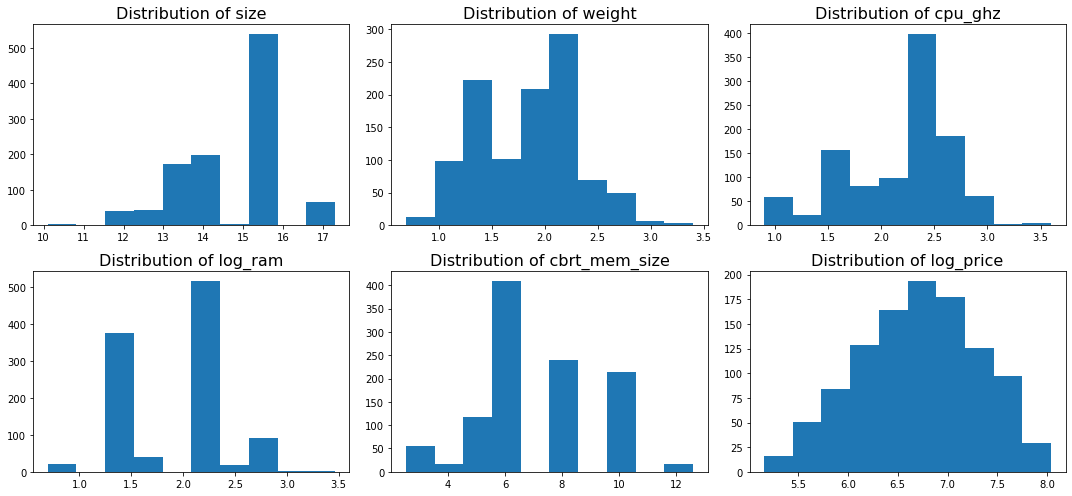

<Figure size 432x288 with 0 Axes>

In [7]:
#Function that plots multiple histograms in a subplot
def histoplotter(columns, fig, axs):
    
    count = 0
    x= -1
        
    for column in columns:
        if count%3 == 0:
            x+=1
        axs[x, count%3].hist(laptop[column])
        axs[x, count%3].set_title(f'Distribution of {column}', fontsize=16)
        count += 1   

    plt.tight_layout()
    plt.show()
    plt.clf()
    return
         
fig, axs = plt.subplots(2, 3, figsize=(15,7))
columns = ['size', 'weight', 'cpu_ghz', 'log_ram', 'cbrt_mem_size', 'log_price']

histoplotter(columns,fig,axs)

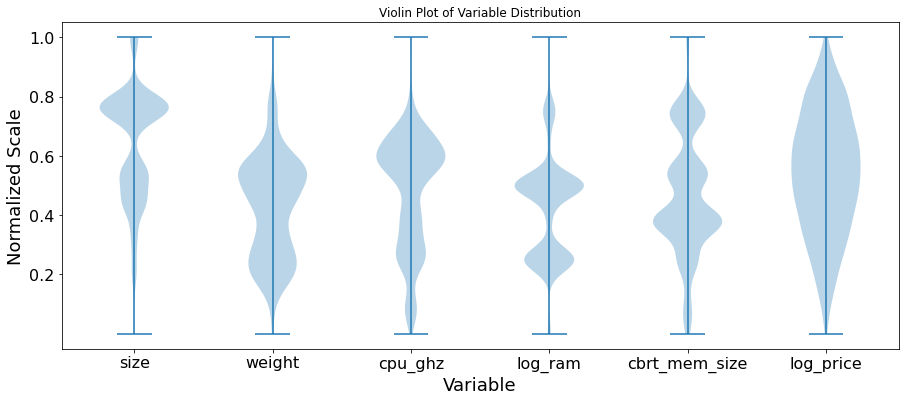

<Figure size 432x288 with 0 Axes>

In [8]:
labels= ['size', 'weight', 'cpu_ghz', 'log_ram', 'cbrt_mem_size', 'log_price']
x_df = laptop.filter(labels, axis=1)

#Normalise values using .MinMaxScaler()
x = x_df.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
scaled_df = pd.DataFrame(x_scaled)

xvars = [scaled_df[0], scaled_df[1], scaled_df[2], scaled_df[3], scaled_df[4], scaled_df[5]]

#Plot normalised variables in Violin Plot
plt.figure(figsize=(15,6))
ax = plt.subplot()
plt.violinplot(xvars)
plt.title('Violin Plot of Variable Distribution')
plt.ylabel('Normalized Scale', fontsize=18)
plt.xlabel('Variable', fontsize=18)
ax.set_xticks(range(1,7,1))
ax.set_xticklabels(labels, fontsize=16)
ax.set_yticks((0.2, 0.4, 0.6, 0.8, 1.0))
ax.set_yticklabels((0.2, 0.4, 0.6, 0.8, 1.0), fontsize=16)

plt.show()
plt.clf()

## 4.2 Correlation of Variables (Multicollinearity)
Another assumption which is important when creating regression models is multicollinearity. In order not to violate this, independent (exploratory) variables must not have an exact relationship between each other. 

A heatmap showing the correlation between variables is shown below. 

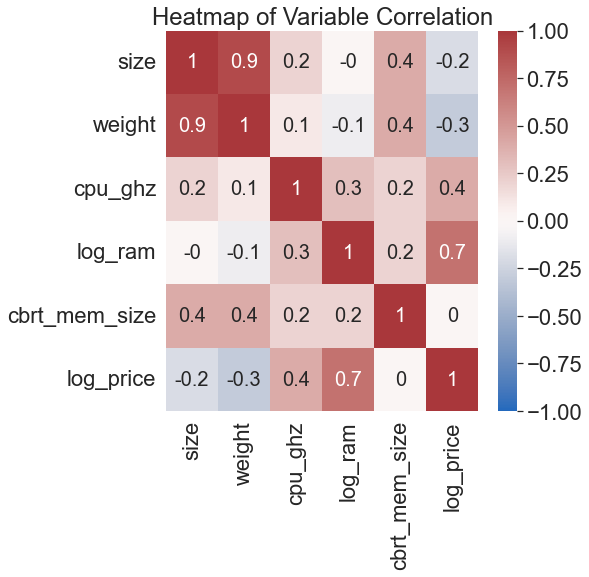

<Figure size 432x288 with 0 Axes>

In [9]:
#Produce correlation grid
corr_grid = round(x_df.corr(),1)

#Use grid to plot heatmap
plt.figure(figsize=(7,7))
sns.set(font_scale=2)
sns.heatmap(corr_grid, vmin=-1, vmax=1, center=0, cmap='vlag', annot=True,
            xticklabels=corr_grid.columns,yticklabels=corr_grid.columns, annot_kws={"fontsize":20})
plt.title('Heatmap of Variable Correlation')

plt.show()
plt.clf()

As identified in the heatmap, there is a very strong relationship between size and weight. This is as expected as naturally when you vary the size of a laptop, the weight will be directly impacted by this.

In order not to violate the multicollinearity assumption we must not create a model in which both size and weight are used as exploratory variables.

## 5 Model Testing
To accurately choose the correct regression model, certain tests can be conducted. As I wish that this model will best represents the current data, as well as being able to adapt to new data entries of new/updated laptops in the future, this project will use the following tests:

- R-squared
- Adjusted R-squared
- F-test
- Log likelihood
- AIC
- BIC

The functions for these model testers are coded below:

In [10]:
def rsq_tester(models):
    values = []
    for model in models:
        values.append(round(model.rsquared,3))
    testdb['R-Squared'] = values

def rsq_adj_tester(models):
    values = []
    for model in models:
        values.append(round(model.rsquared_adj,3))
    testdb['R-Squared Adj'] = values
    
def llf_tester(models):
    values = []
    for model in models:
        values.append(round(model.llf,3).astype('int64'))
    testdb['Log-Likelihood'] = values

def aic_tester(models):
    values = []
    for model in models:
        values.append(round(model.aic,3).astype('int64'))
    testdb['AIC'] = values
    
def bic_tester(models):
    values = []
    for model in models:
        values.append(round(model.bic,3).astype('int64'))
    testdb['BIC'] = values

## 6. Results & Discussion
### 6.1 Laptop Size Regression Model
First we will look at the relationship between laptop size and price, with an added factor of touchscreen ability.

Initially we will look at a scatter plot of the 2 variables to see if it suggests anything about the relationship. This will be done by using the function below.

In [11]:
#Function that plots a scatter plot of price vs xvar, and also takes a categorical variable
def scatter_plotter(xvar, binvar, markers):
    sns.lmplot(x=xvar, y='log_price', data=laptop, hue=binvar, fit_reg=False, line_kws={'linewidth':3},
                scatter_kws={'alpha':0.8, 's':150}, markers=markers, height=6, aspect=2, legend=False)
    plt.title(f'Scatter Plot - log(Laptop Price) vs {xvar.title()}', fontsize=20)
    plt.xlabel(xvar.title(), fontsize=16)
    plt.ylabel('log(Laptop Price (€))', fontsize=16)
    plt.tick_params(axis='both', labelsize=16)
    plt.legend(title=binvar.title(), title_fontsize=14, fontsize=14)
    plt.show()
    plt.clf()
    return

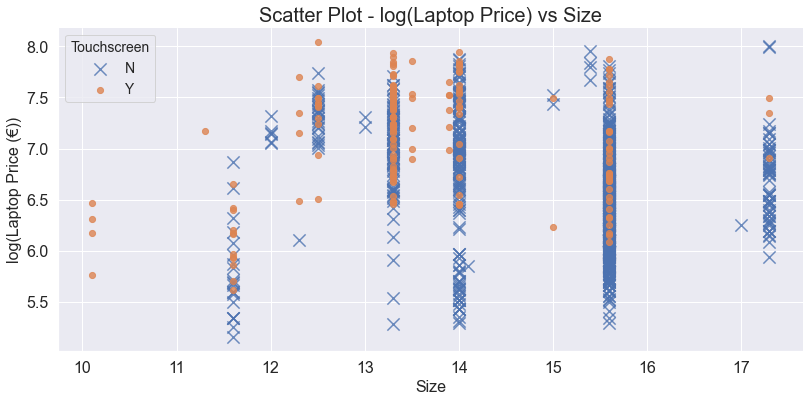

<Figure size 432x288 with 0 Axes>

In [12]:
#Use function to plot scatter graph of price vs size
xvars = 'size'
binvar = 'touchscreen'
markers = ['x', '.']
scatter_plotter(xvars,binvar, markers)

The scatter graph suggests a slight polynomial regression between the 2 variables with price at its maximum around 14 & 15.6 inches, with it declining after that. This trend seems similar for both Touchscreen options, yet Touchscreen laptops seem to have a larger price in general.

Due to these observations, we will use a polynomial model with size^2 and also an added interaction between size:touchscreen. 

ModelS = log_price ~ size + touchscreen + size:touchscreen + np.power(size,2)

Next we shall plot a histogram and scatter plot of the residuals to check for normality and homoscedasticity, and print the models parameters as well.

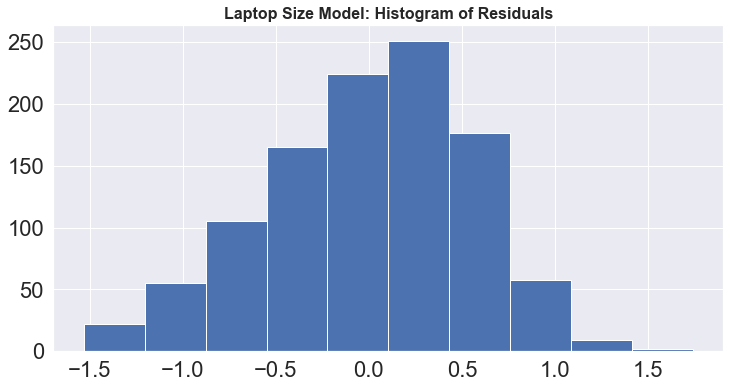

<Figure size 432x288 with 0 Axes>

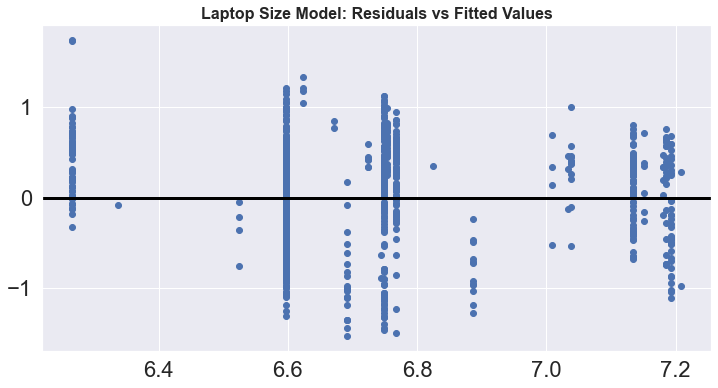

Intercept                1.549033
touchscreen[T.Y]        -0.969143
size                     0.790416
size:touchscreen[T.Y]    0.100363
np.power(size, 2)       -0.029927
dtype: float64


<Figure size 432x288 with 0 Axes>

In [13]:
modelS = sm.OLS.from_formula('log_price ~ size + touchscreen + size:touchscreen + np.power(size,2)', data=laptop).fit()

# Save fitted values and residuals for ModelS
fitted_valuesS = modelS.predict(laptop)
residualsS = laptop.log_price - fitted_valuesS

#Plot histogram of residuals to check for normality
plt.figure(figsize=(12,6))
plt.hist(residualsS)
plt.title('Laptop Size Model: Histogram of Residuals', fontsize=16, weight='bold')
plt.show()
plt.clf()

#Plot scatter graph of residuals to check for homoscedasticity
plt.figure(figsize=(12,6))
plt.scatter(fitted_valuesS, residualsS)
plt.axhline(y=0, color='black', linestyle='-', linewidth=3)
plt.title('Laptop Size Model: Residuals vs Fitted Values', fontsize=16, weight='bold')
plt.show()
plt.clf()

#print ModelS parameters
print(modelS.params)

From the graphs, this model doesnt seem to violate any assumptions. Therefore, we can continue to use it for our polynomial regression model.

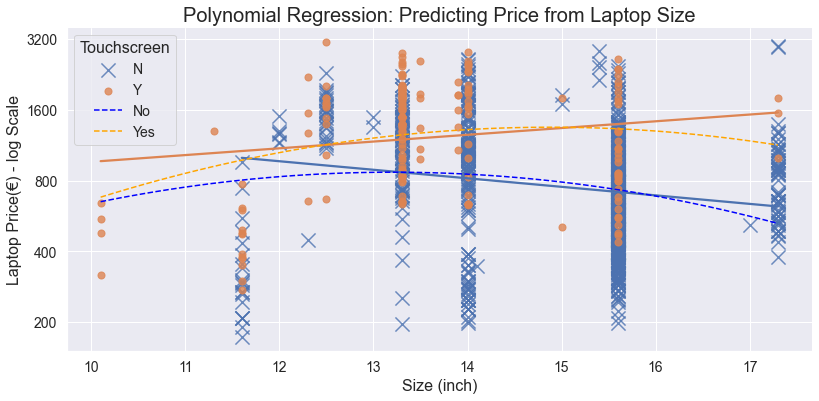

<Figure size 432x288 with 0 Axes>

In [14]:
#Calculate y_values from range of x_values and ModelS.params for both touchscreen and not.
x=np.linspace(10.1,17.3,50)
y_t= modelS.params[0] + modelS.params[1] + modelS.params[2]*x + modelS.params[3]*x + modelS.params[4]*np.power(x,2)
y_no = modelS.params[0] + modelS.params[2]*x + modelS.params[4]*np.power(x,2)

#Plot scattergraph of price vs size
sns.lmplot(x='size', y='log_price', data=laptop, ci=False, scatter_kws={'alpha':0.8, 's':200},
           hue='touchscreen', markers=['x', '.'], height=6, aspect=2, legend=False)

#Plot polynomial regression lines on scatter graph
plt.plot(x, y_no, color='blue', linestyle='dashed', label='No')
plt.plot(x, y_t, color='orange', linestyle='dashed', label='Yes')

#Format Graph
plt.title('Polynomial Regression: Predicting Price from Laptop Size', fontsize=20)
plt.xlabel('Size (inch)', fontsize=16)
plt.ylabel('Laptop Price(€) - log Scale', fontsize=16)
plt.yticks((5.3, 5.992, 6.685, 7.3778, 8.07091),
           (int(np.exp(5.3)), int(np.exp(5.992)), int(np.exp(6.685)), int(np.exp(7.3778)), int(np.exp(8.07091))), fontsize=14)
plt.xticks((range(10,18,1)), (range(10,18,1)), fontsize=14)
plt.legend(title='Touchscreen', title_fontsize=16, fontsize=14)

plt.show()
plt.clf()

* The dashed lines show a polynomial regression line between price and size for both touchscreen and non-touchscreen laptops.
* As displayed, the regression lines give a more accurate trend line than the preset linear trend shown by the full lines.
* As expected, laptop price peaks at 14 inches for non-touch and 15.6 inches for touchscreen laptops.
* This could suggest that laptops that are more portable (smaller) are more valuable, up to a point where a too small screen may be impractical
* Also, touchscreen laptops have a greater size before they depreciate suggesting its more functional and practical to have a larger screen on a touchscreen laptop.

### 6.2 CPU Regression Model
Next, a regression model of price vs cpu_ghz will be produced with the added factor of CPU Brand.

Firstly, the a scatter plot is created.

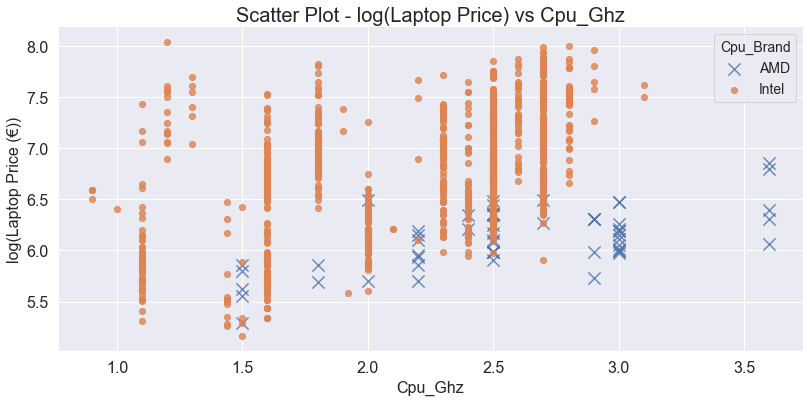

<Figure size 432x288 with 0 Axes>

In [15]:
scatter_plotter('cpu_ghz', 'cpu_brand', ['x', '.'])

* The graph indicates a clear positive linear trend between price and CPU power for both CPU Brands
* It seems that Intel CPU laptops are usually more expensive than AMD for the same CPU Power
* However, AMD produce more powerful laptops, reaching 3.6 GHz compared to Intel's 3.1 GHz
* Intel also produce more low end laptops with their minimum CPU power being 0.9 GHz

Next, 5 multiple linear regression models will be tested to see which factors are attributed to a more accurate model.
* model1 = log_price ~ cpu_ghz + weight
* model2 = log_price ~ cpu_ghz + log_ram
* model3 = log_price ~ cpu_ghz + cbrt_mem_size
* model4= log_price ~ cpu_ghz + cpu_brand
* model5= log_price ~ cpu_ghz + touchscreen

In [16]:
#Fit 5 Models using OLS
model1 = sm.OLS.from_formula('log_price ~ cpu_ghz + weight', data=laptop).fit()
model2 = sm.OLS.from_formula('log_price ~ cpu_ghz + log_ram', data=laptop).fit()
model3 = sm.OLS.from_formula('log_price ~ cpu_ghz + cbrt_mem_size', data=laptop).fit()
model4= sm.OLS.from_formula('log_price ~ cpu_ghz + cpu_brand', data=laptop).fit()
model5= sm.OLS.from_formula('log_price ~ cpu_ghz + touchscreen', data=laptop).fit()

#Create test database for 5 models
row_names = ['model1', 'model2', 'model3', 'model4', 'model5']
testdb = pd.DataFrame(row_names, index=['1', '2', '3', '4', '5'], columns=['Model'])

#Test models and insert values into testdb
models = [model1, model2, model3, model4, model5]
rsq_tester(models)
rsq_adj_tester(models)
llf_tester(models)
aic_tester(models)
bic_tester(models)

#Highlight best model from each test in green
testdb1 = testdb.style\
      .highlight_max(subset=['R-Squared', 'R-Squared Adj','Log-Likelihood'], color = 'lightgreen')\
      .highlight_min(subset=['AIC', 'BIC'], color = 'lightgreen')\

display(testdb1)

,Model,R-Squared,R-Squared Adj,Log-Likelihood,AIC,BIC
1,model1,0.302000,0.300000,-758,1523,1538
2,model2,0.573000,0.572000,-496,998,1013
3,model3,0.174000,0.172000,-848,1702,1717
4,model4,0.270000,0.268000,-782,1570,1585
5,model5,0.272000,0.271000,-780,1567,1582


The model tests unanimously agree that model2 is the best predictor of laptop price.
One final test (FTest) will be conducted between model2 and model6 which consists of model2 with an additional cpu_ghz:log_ram interaction.
* model6= log_price ~ cpu_ghz + log_ram + cpu_ghz:log_ram

In [17]:
model6= sm.OLS.from_formula('log_price ~ cpu_ghz + log_ram + cpu_ghz:log_ram', data=laptop).fit()

#Calculate FTest Results
anova_results = anova_lm(model2, model6)
print(anova_results)
print('')
print(f'The p_value for the Ftest between model2 & model6 is 6.690781e-09')

print(f'The R-Squared value for model6 is {round(model6.rsquared,3)}')

   df_resid         ssr  df_diff   ss_diff          F        Pr(>F)
0    1064.0  158.428811      0.0       NaN        NaN           NaN
1    1063.0  153.493852      1.0  4.934959  34.176364  6.690781e-09

The p_value for the Ftest between model2 & model6 is 6.690781e-09
The R-Squared value for model6 is 0.586


Using a significance threshold of 0.05, The results of the FTest indicate that there is a significant advantage with using model6. The R-Squared value for model6 is 0.586 which is also an improvement on model2.

Therefore, model6 will be used to create a multiple regression line. However, before we do so, we must again check the residuals.

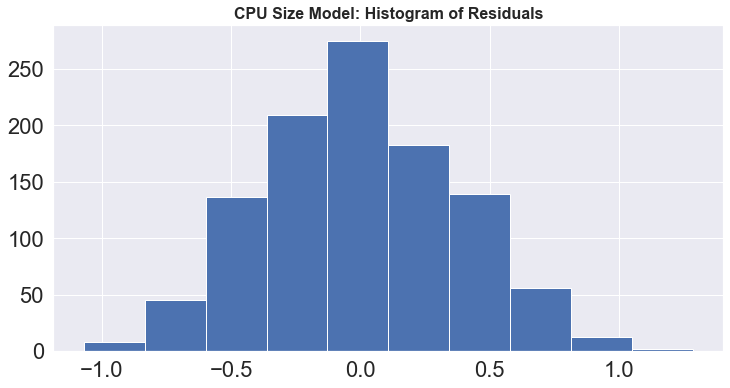

<Figure size 432x288 with 0 Axes>

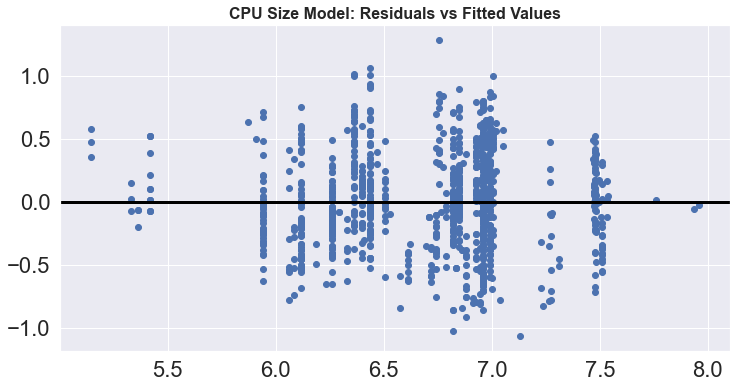

Intercept          3.525012
cpu_ghz            0.743912
log_ram            1.463979
cpu_ghz:log_ram   -0.282866
dtype: float64


<Figure size 432x288 with 0 Axes>

In [18]:
modelGhz=sm.OLS.from_formula('log_price ~ cpu_ghz + log_ram + cpu_ghz:log_ram', data=laptop).fit()

#Saved fitted values and residuals for modelGHZ
fitted_valuesGhz = modelGhz.predict(laptop)
residualsGhz = laptop.log_price - fitted_valuesGhz

#Plot histogram of residuals to check for normality
plt.figure(figsize=(12,6))
plt.hist(residualsGhz)
plt.title('CPU Size Model: Histogram of Residuals', fontsize=16, weight='bold')
plt.show()
plt.clf()

#Plot scatter graph of residuals to check for homoscedasticity
plt.figure(figsize=(12,6))
plt.scatter(fitted_valuesGhz, residualsGhz)
plt.axhline(y=0, color='black', linestyle='-', linewidth=3)
plt.title('CPU Size Model: Residuals vs Fitted Values', fontsize=16, weight='bold')
plt.show()
plt.clf()

#print modelGhz parameters
print(modelGhz.params)

From the graphs, this model doesnt seem to violate any assumptions. Therefore, we can continue to use it for our two quantative multiple regression model.

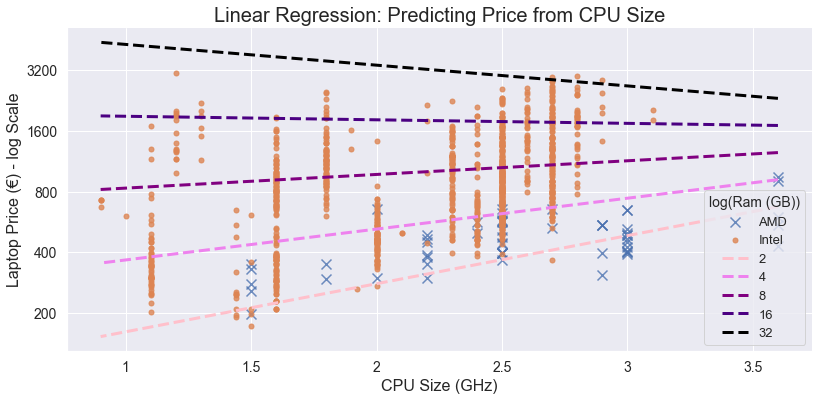

<Figure size 432x288 with 0 Axes>

In [19]:
#Plot scatter plot of price vs cpu_ghz with cpu_brand as hue
sns.lmplot(x='cpu_ghz', y='log_price', data=laptop, fit_reg=False, height=6, aspect=2,
           hue='cpu_brand', legend=False, markers=['x', '.'],scatter_kws={'alpha':0.8, 's':100})

#Use modelGhz.params to plot linear regression when RAM equals 2, 4, 8, 16, 32 GB on scatter plot
plt.plot(laptop.cpu_ghz, modelGhz.params[0] + modelGhz.params[1]*laptop.cpu_ghz
         + modelGhz.params[2]*np.log(2) + modelGhz.params[3]*laptop.cpu_ghz*np.log(2),
         color='pink', linestyle='dashed', linewidth=3, label='2')

plt.plot(laptop.cpu_ghz, modelGhz.params[0] + modelGhz.params[1]*laptop.cpu_ghz
         + modelGhz.params[2]*np.log(4) + modelGhz.params[3]*laptop.cpu_ghz*np.log(4),
         color='violet', linestyle='dashed', linewidth=3, label='4')

plt.plot(laptop.cpu_ghz, modelGhz.params[0] + modelGhz.params[1]*laptop.cpu_ghz
         + modelGhz.params[2]*np.log(8) + modelGhz.params[3]*laptop.cpu_ghz*np.log(8),
         color='purple', linestyle='dashed', linewidth=3, label='8')

plt.plot(laptop.cpu_ghz, modelGhz.params[0] + modelGhz.params[1]*laptop.cpu_ghz
         + modelGhz.params[2]*np.log(16) + modelGhz.params[3]*laptop.cpu_ghz*np.log(16),
         color='indigo', linestyle='dashed', linewidth=3, label='16')

plt.plot(laptop.cpu_ghz, modelGhz.params[0] + modelGhz.params[1]*laptop.cpu_ghz
         + modelGhz.params[2]*np.log(32) + modelGhz.params[3]*laptop.cpu_ghz*np.log(32),
         color='black', linestyle='dashed', linewidth=3, label='32')

#Format Graph
plt.title('Linear Regression: Predicting Price from CPU Size', fontsize=20)
plt.ylabel('Laptop Price (€) - log Scale', fontsize=16)
plt.xlabel('CPU Size (GHz)', fontsize=16)
plt.yticks((5.3, 5.992, 6.685, 7.3778, 8.07091),
           (int(np.exp(5.3)), int(np.exp(5.992)), int(np.exp(6.685)), int(np.exp(7.3778)), int(np.exp(8.07091))), fontsize=14)
plt.xticks((1, 1.5, 2, 2.5, 3, 3.5), (1, 1.5, 2, 2.5, 3, 3.5), fontsize=14)
plt.legend(title="log(Ram (GB))", fontsize=13, title_fontsize=14)
plt.show()
plt.clf()

* The lower the RAM, the greater increase in price when CPU Size is increased.
* This may suggest that higher RAM laptops are already expensive, so an increase in CPU doesnt necessarily have a large affect on the price.
* Laptops with large RAM and CPU size may also include other undesirable specifications such as increased size and weight

### 6.3 Memory Size Regression Model
Next, a regression model of price vs memory size will be produced with the added factor of Memory Type.

Firstly, the a scatter plot is created.

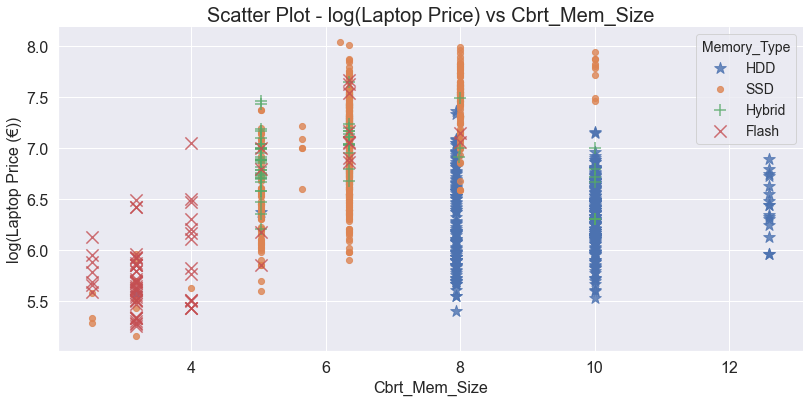

<Figure size 432x288 with 0 Axes>

In [20]:
scatter_plotter('cbrt_mem_size', 'memory_type', ['*', '.', '+', 'x'])

* HDD type memory laptops all have a large amount of memory but are not necessarily the most expensive. The trend may be linear but is unclear.
* SSD type memory laptops are amongst the most expensive with a large range of values. The trend seems poistive and linear
* Hybrid type memory laptops seem to have a slight negative linear trend.
* Flash drive type memory laptops usually have small amounts of memory and can get expensive in larger memory laptops.
* The overall trend is unclear and futher analysis must be undertaken.

Next, 5 multiple linear regression models will be tested to see which factors are attributed to a more accurate model. This time the trend between factors is unclear, so the models are both linear and polynomial.
* model1 = log_price ~ cbrt_mem_size  + memory_type
* model2 = log_price ~ cbrt_mem_size  + memory_type + cbrt_mem_size:memory_type
* model3 = log_price ~ cbrt_mem_size + memory_type + np.power(cbrt_mem_size,2)
* model4 = log_price ~ cbrt_mem_size + cbrt_mem_size:memory_type + np.power(cbrt_mem_size,2)
* model5 = log_price ~ cbrt_mem_size + memory_type + cbrt_mem_size:memory_type + np.power(cbrt_mem_size,2)

An Ftest is also perform between the best 2 models with a significance threshold of 0.05

In [21]:
#Fit 5 models using OLS
model1 = sm.OLS.from_formula('log_price ~ cbrt_mem_size  + memory_type',
                             data=laptop).fit()
model2 = sm.OLS.from_formula('log_price ~ cbrt_mem_size  + memory_type + cbrt_mem_size:memory_type',
                             data=laptop).fit()
model3 = sm.OLS.from_formula('log_price ~ cbrt_mem_size + memory_type + np.power(cbrt_mem_size,2)',
                             data=laptop).fit()
model4 = sm.OLS.from_formula('log_price ~ cbrt_mem_size + cbrt_mem_size:memory_type + np.power(cbrt_mem_size,2)',
                            data=laptop).fit()
model5 = sm.OLS.from_formula('log_price ~ cbrt_mem_size + memory_type + cbrt_mem_size:memory_type + np.power(cbrt_mem_size,2)',
                            data=laptop).fit()

#Create test database for 5 models
testdb = pd.DataFrame(row_names, index=['1', '2', '3', '4', '5'], columns=['Model'])
row_names = ['model1', 'model2', 'model3', 'model4', 'model5']

#Test models and insert values into testdb
models = [model1, model2, model3, model4, model5]
rsq_tester(models)
rsq_adj_tester(models)
llf_tester(models)
aic_tester(models)
bic_tester(models)

#Highlight best model from each test in green
testdb1 = testdb.style\
      .highlight_max(subset=['R-Squared', 'R-Squared Adj','Log-Likelihood'], color = 'lightgreen')\
      .highlight_min(subset=['AIC', 'BIC'], color = 'lightgreen')\

display(testdb1)

#Perform FTest between top 2 models to see significance
anova_results = anova_lm(model2, model5)
print(anova_results)
print('')
print(f'The p_value for the Ftest between model2 & model5 is 0.00001')

,Model,R-Squared,R-Squared Adj,Log-Likelihood,AIC,BIC
1,model1,0.503000,0.501000,-577,1164,1189
2,model2,0.602000,0.599000,-458,932,972
3,model3,0.574000,0.572000,-494,1001,1031
4,model4,0.574000,0.572000,-494,1001,1030
5,model5,0.609000,0.606000,-448,915,960


   df_resid         ssr  df_diff   ss_diff          F   Pr(>F)
0    1059.0  147.534654      0.0       NaN        NaN      NaN
1    1058.0  144.846048      1.0  2.688605  19.638399  0.00001

The p_value for the Ftest between model2 & model5 is 0.00001


All tests including the Ftest point to model5 being the best predictor model. This suggests that the relationship is then polynomial and not linear.

Next, the residuals of model5 are tested to determine normality and homoscedasticity.

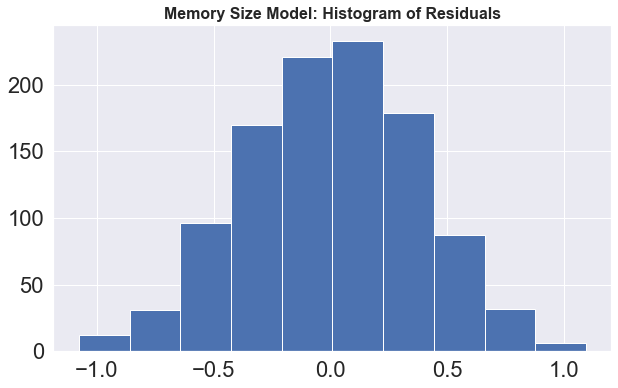

<Figure size 432x288 with 0 Axes>

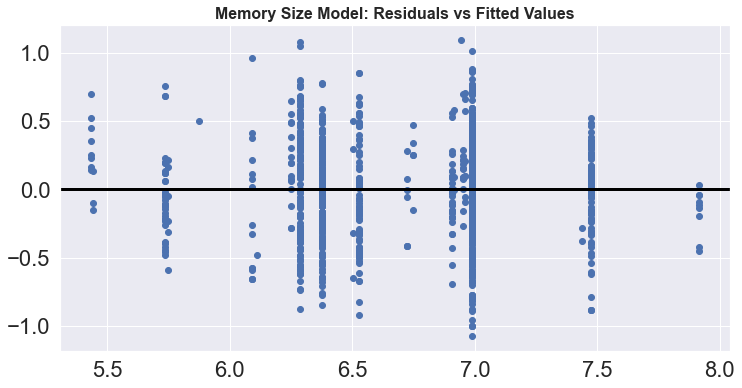

Intercept                              4.107789
memory_type[T.HDD]                     0.254944
memory_type[T.Hybrid]                  1.981567
memory_type[T.SSD]                     0.000550
cbrt_mem_size                          0.575596
cbrt_mem_size:memory_type[T.HDD]      -0.175110
cbrt_mem_size:memory_type[T.Hybrid]   -0.313180
cbrt_mem_size:memory_type[T.SSD]       0.004356
np.power(cbrt_mem_size, 2)            -0.019912
dtype: float64


<Figure size 432x288 with 0 Axes>

In [22]:
modelMem=sm.OLS.from_formula('log_price ~ cbrt_mem_size + memory_type + cbrt_mem_size:memory_type + np.power(cbrt_mem_size,2)',
                             data=laptop).fit()

#Saved fitted values and residuals of model
fitted_valuesMem = modelMem.predict(laptop)
residualsMem = laptop.log_price - fitted_valuesMem

#Plot histogram of residuals to check for normality
plt.figure(figsize=(10,6))
plt.hist(residualsMem)
plt.title('Memory Size Model: Histogram of Residuals', fontsize=16, weight='bold')
plt.show()
plt.clf()

#Plot scatter graph of residuals to check for homoscedasticity
plt.figure(figsize=(12,6))
plt.scatter(fitted_valuesMem, residualsMem)
plt.axhline(y=0, color='black', linestyle='-', linewidth=3)
plt.title('Memory Size Model: Residuals vs Fitted Values', fontsize=16, weight='bold')
plt.show()
plt.clf()

#print modelGhz parameters
print(modelMem.params)

From the graphs, this model doesnt seem to violate any assumptions. Therefore, we can continue to use it for our polynomial multiple regression model.

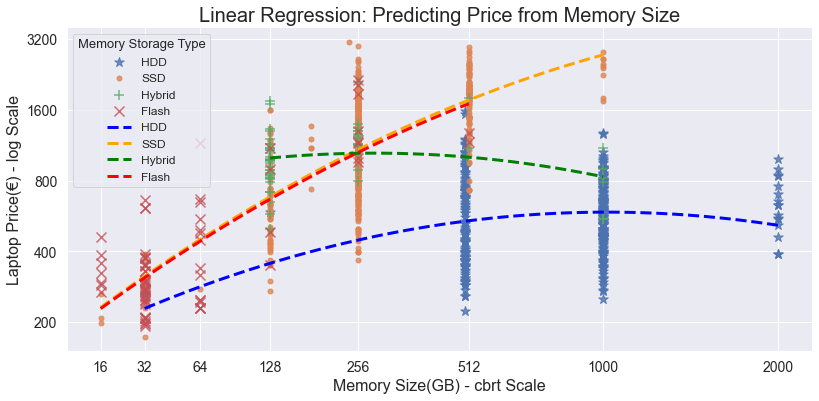

<Figure size 432x288 with 0 Axes>

In [23]:
#Determine x_value min and max for each storage type
x_hdd = np.linspace(min(laptop.cbrt_mem_size[laptop.memory_type == 'HDD']),
                    max(laptop.cbrt_mem_size[laptop.memory_type == 'HDD']),100)

x_hybrid = np.linspace(min(laptop.cbrt_mem_size[laptop.memory_type == 'Hybrid']),
                       max(laptop.cbrt_mem_size[laptop.memory_type == 'Hybrid']),100)

x_ssd = np.linspace(min(laptop.cbrt_mem_size[laptop.memory_type == 'SSD']),
                    max(laptop.cbrt_mem_size[laptop.memory_type == 'SSD']),100)

x_flash = np.linspace(min(laptop.cbrt_mem_size[laptop.memory_type == 'Flash']),
                      max(laptop.cbrt_mem_size[laptop.memory_type == 'Flash']),100)


#Plot scatter graph of price vs memory size with memory storage type as the hue
ax = sns.lmplot(x='cbrt_mem_size', y='log_price', data=laptop, fit_reg=False, hue='memory_type',
                scatter_kws={'alpha':0.8, 's':100}, markers=['*', '.', '+', 'x'], height=6, aspect=2, legend=False)


#Plot the regression lines of each memory storage type
plt.plot(x_hdd, modelMem.params[0] + modelMem.params[1] + modelMem.params[4]*x_hdd
         + modelMem.params[5]*x_hdd + modelMem.params[8]*np.power(x_hdd,2),
         color='blue', label='HDD', linestyle='dashed', linewidth=3)

plt.plot(x_ssd, modelMem.params[0] + modelMem.params[3] + modelMem.params[4]*x_ssd
         + modelMem.params[7]*x_ssd + modelMem.params[8]*np.power(x_ssd,2),
         color='orange', label='SSD', linestyle='dashed', linewidth=3)

plt.plot(x_hybrid, modelMem.params[0] + modelMem.params[2] + modelMem.params[4]*x_hybrid
         + modelMem.params[6]*x_hybrid + modelMem.params[8]*np.power(x_hybrid,2),
         color='green', label='Hybrid', linestyle='dashed', linewidth=3)

plt.plot(x_flash, modelMem.params[0] + modelMem.params[4]*x_flash + modelMem.params[8]*np.power(x_flash,2),
         color='red', label='Flash', linestyle='dashed', linewidth=3)

#Format graph
plt.title('Linear Regression: Predicting Price from Memory Size', fontsize=20)
plt.ylabel('Laptop Price(€) - log Scale', fontsize=16)
plt.xlabel('Memory Size(GB) - cbrt Scale', fontsize=16)

plt.xticks((2.52, 3.175, 4, 5.04, 6.35, 8, 10, 12.6),
           (int(np.power(2.52,3)), int(np.power(3.175,3)), int(np.power(4,3)), int(np.power(5.04,3)), int(np.power(6.35,3)),
            int(np.power(8,3)), int(np.power(10,3)), int(np.power(12.6,3))), fontsize=14)
plt.yticks((5.3, 5.992, 6.685, 7.3778, 8.07091),
           (int(np.exp(5.3)), int(np.exp(5.992)), int(np.exp(6.685)), int(np.exp(7.3778)), int(np.exp(8.07091))), fontsize=14)

plt.legend(fontsize=12, title='Memory Storage Type', title_fontsize=13)
plt.show()
plt.clf()

* HDD Storage laptops are shown to be the cheapest on the market, even those with a large Memory. Their price peaks for the 1TB model and declines after this, perhaps due to an increase in size or weight.
* SSD and Flash models follow a similar trend with price increasing greatly for every extra GB of memory
* The main difference between these types is that Flash models are usually more low-end whereas SSD are some of the most expensive laptops on the market.
* Hybrid storage laptops are the most expensive laptops with a 128GB memory but fall off after 256GB and depreciate slightly in value, suggesting the Hybrid storage type is less desireable and effective at higher memory capacities.

### 6.3 Effect of Company and Operating System on Price
This next section analyzes which companies and operating systems produce the most and least expensive laptops on the market. This is achieved by comparing their mean prices in the bar charts below.

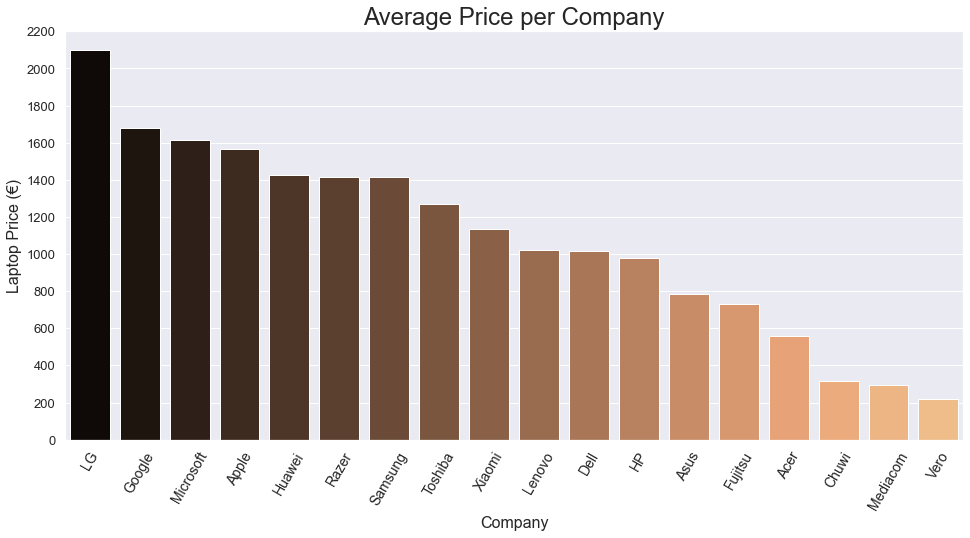

<Figure size 432x288 with 0 Axes>

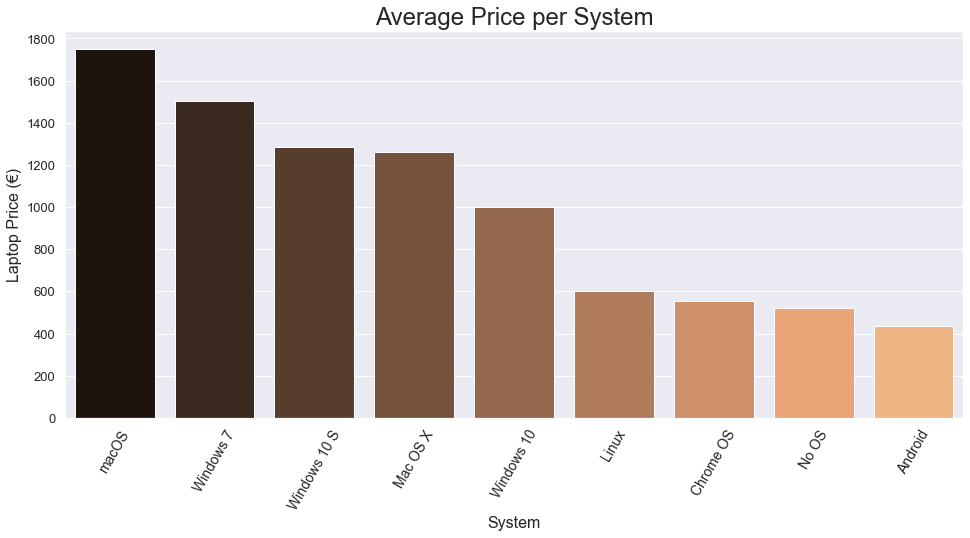

<Figure size 432x288 with 0 Axes>

In [24]:
def bar_plotter(xvars):
    for var in xvars:
        avg = laptop.groupby(var).mean()
        avg = avg.sort_values('price_eu', ascending=False)
        
        plt.figure(figsize=(14,8))
        ax=plt.subplot()
        sns.barplot(x=avg.index, y=avg.price_eu, palette='copper')
        
        plt.title(f'Average Price per {var.title()}')
        plt.xlabel(var.title(), fontsize=16)
        plt.ylabel('Laptop Price (€)', fontsize=16)
        ax.set_xticks(range(0,len(laptop[var].unique()),1))
        ax.set_xticklabels(avg.index,rotation=60, fontsize=14)
        ax.set_yticks(range(0,int(avg.price_eu.max())+200,200))
        ax.set_yticklabels(range(0,int(avg.price_eu.max())+200,200), fontsize=13)
        
        plt.tight_layout()
        plt.show()
        plt.clf()
    return

xvars = ['company', 'system']
bar_plotter(xvars)

* LG produce on average the most expensive computers with an average price of around 2100 Euros, while Vero focus more on the budget laptops with a mean of just over 200 Euros.
* macOS is the operating system of the most expensive laptops on average, maybe due to it being the main operating system for Apple computers a high-end brand. In fact, this correlation can be seen with Apple and macOS both average around 1600-1700 Euros.
* Android operating system is present on the cheapest devices with a mean of just over 400 Euros.
* Interestingly, Windows 7, an older version of Windows 10 and 10S has a greater average price. This is the same for macOS and MacOS X.

### 6.4 Effect of Screen Resolution On Price
This section discusses screen resolution and dives deeper into the touchscreen feature. Screen resolution is an ordinal categorical variable so can be ordered into a rank. Therefore, we will see what affect increasing the resolution has on the price. A linear trendline will also be plotted onto the graph which is developed from the average price for each laptop using the original laptop dataframe.

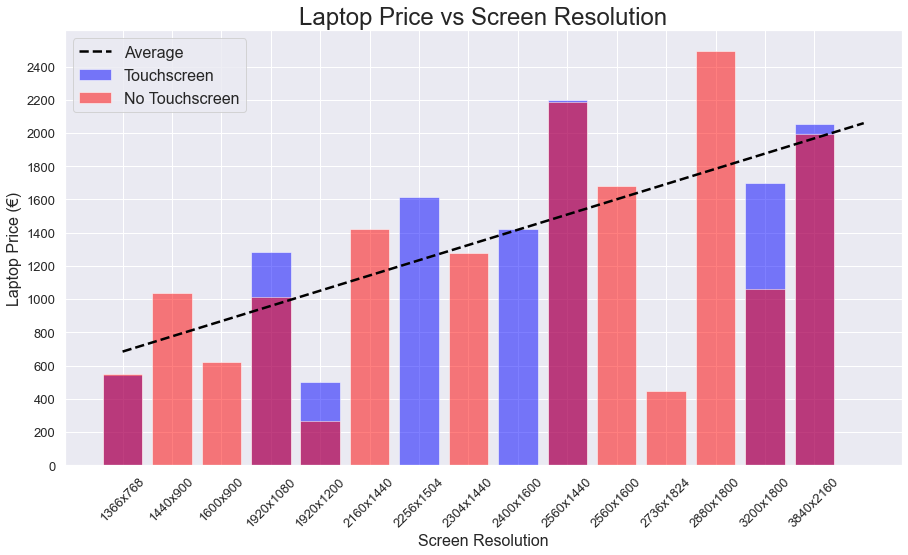

<Figure size 432x288 with 0 Axes>

In [25]:
touch = laptop[laptop.touchscreen == 'Y']
no_touch = laptop[laptop.touchscreen == 'N']

#Mean price for eahc resolution for touchscreen, non-touchscreen and the laptop df average 
avg_t = touch.groupby('res').mean()
avg_no_t = no_touch.groupby('res').mean()
avg_laptop =  laptop.groupby('res').mean()

res_unique = ['1366x768', '1440x900', '1600x900', '1920x1080', '1920x1200', '2160x1440',
              '2256x1504','2304x1440', '2400x1600', '2560x1440', '2560x1600', '2736x1824',
              '2880x1800', '3200x1800', '3840x2160']

#Create dataframe with unique resolutions in first column
df = pd.DataFrame(res_unique, index=range(0,15,1), columns=['res'])

#Add mean price for touchscreen laptops for each resolution, filling in 0 for NaN values
touch_lst = []
for res in res_unique:
    touch_df = avg_t[avg_t.index == res]
    mean = touch_df['price_eu'].mean()
    touch_lst.append(mean)
df['touch'] = touch_lst
df['touch'] = df.touch.fillna(0)

#Add mean price for non-touchscreen laptops for each resolution, filling in 0 for NaN values
no_touch_lst = []
for res in res_unique:
    no_touch_df = avg_no_t[avg_no_t.index == res]
    mean = no_touch_df['price_eu'].mean()
    no_touch_lst.append(mean)
df['no_touch'] = no_touch_lst
df['no_touch'] = df.no_touch.fillna(0)

#Set x_values as screen resolutions in order of increasing quality
#Set y_values as mean price from df
x=df.res
y_t=df.touch
y_n=df.no_touch

#Set x and y_values for laptop df average
x_lap =avg_laptop.index
y_lap =avg_laptop.price_eu

plt.figure(figsize=(15,8))
ax=plt.subplot()

#Plot bars of touchscreen and non-touchscreen data
plt.bar(x, height=y_t, color='blue', alpha=0.5, label='Touchscreen')
plt.bar(x, height=y_n, color='red', alpha=0.5, label='No Touchscreen')

#Plot linear trend line for laptop df average
b_l, a_l = np.polyfit(range(0,15,1), y_lap, deg=1)
xseq = np.linspace(0, 15, num=100)
ax.plot(xseq, a_l + b_l*xseq, lw=2.5, color='black', linestyle='dashed', label='Average')

#Format Graph
plt.title('Laptop Price vs Screen Resolution')
plt.xlabel('Screen Resolution', fontsize=16)
plt.ylabel('Laptop Price (€)', fontsize=16)
ax.set_xticks(range(0,15,1))
ax.set_xticklabels(res_unique,rotation=45, fontsize=13)
ax.set_yticks(range(0,2600,200))
ax.set_yticklabels(range(0,2600,200),fontsize=13)

plt.legend(fontsize=16)
plt.show()
plt.clf()

* There is a positive trend between price and improved screen resolution.
* There are only touchscreen laptops with specific resolutions on the market, but they are always more expensive than non-touchscreen laptops of the same resolution.
* There is a large anomaly at resolution 2736x1824 which averages a very low price of around 400 Euros. After inspecting the data further, there is only 1 laptop with this specific screen resolution, so this anomaly can be put down to a small sample size.
* The resolution with the highest mean price is 2880x1800.

### 6.5 Effect of Touchscreen and Laptop Type on Price

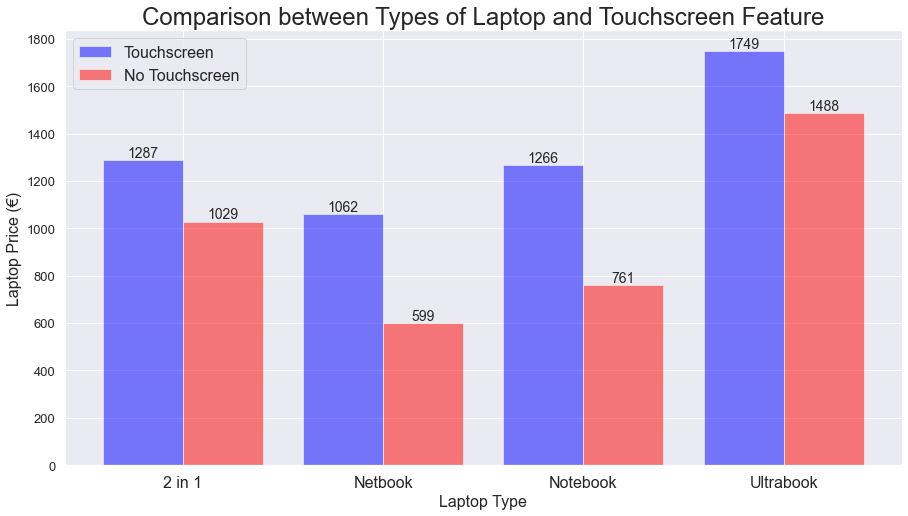

<Figure size 432x288 with 0 Axes>

In [26]:
touchdf = round(touch.groupby('type').mean(),0)
touch_price = touchdf.price_eu.tolist()

no_touchdf = round(no_touch.groupby('type').mean(),0)
no_touch_price = no_touchdf.price_eu.tolist()

N=4
ind = np.arange(N)
width=0.2
    
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)   

plt.bar(ind-width, touch_price, width=width*2, color='blue', label='Touchscreen', alpha=0.5)
plt.bar(ind+width, no_touch_price, width=width*2, color='red', label='No Touchscreen', alpha=0.5)

plt.title('Comparison between Types of Laptop and Touchscreen Feature')
plt.ylabel('Laptop Price (€)', fontsize=16)
plt.xlabel('Laptop Type', fontsize=16)

ax.set_xticks(range(0,N,1))
ax.set_xticklabels(no_touchdf.index, fontsize=16)
ax.set_yticks(range(0,2000,200))
ax.set_yticklabels(range(0,2000,200), fontsize=13)

for bars in ax.containers:
    ax.bar_label(bars, fontsize=14)
    
plt.legend(fontsize=16)
plt.show()
plt.clf()

* This graph gives us more proof that the Touchscreen feature increases a laptops market value, this time it is independent of which type of laptop it is.
* Ultrabooks are the most expensive laptop and Netbooks are on average the cheapest.

### 6.6 Effect of GPU on Price

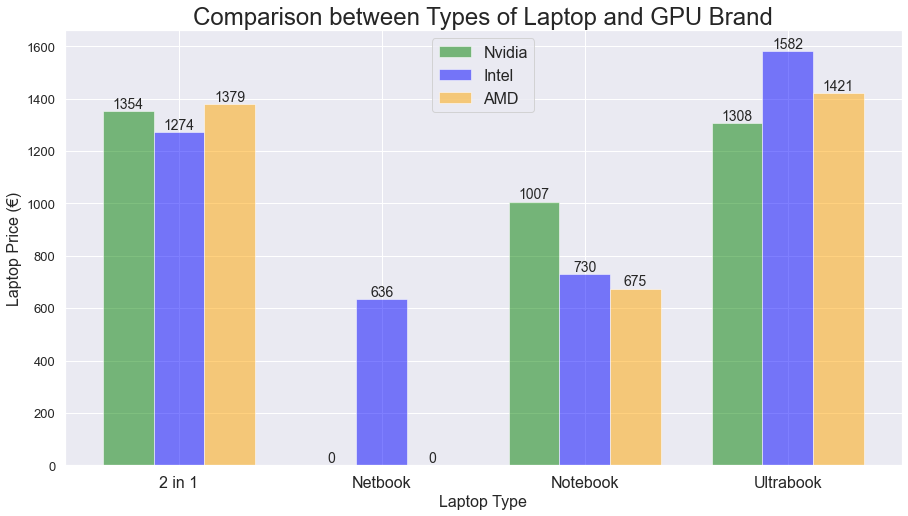

<Figure size 432x288 with 0 Axes>

In [27]:
nvid = laptop[laptop.gpu_brand == 'Nvidia']
nviddf = round(nvid.groupby('type').mean(),0)
nvid_price = nviddf.price_eu.tolist()
nvid_price.insert(1, 0)

inte = laptop[laptop.gpu_brand == 'Intel']
intedf = round(inte.groupby('type').mean(),0)
inte_price = intedf.price_eu.tolist()

amd = laptop[laptop.gpu_brand == 'AMD']
amddf = round(amd.groupby('type').mean(),0)
amd_price = amddf.price_eu.tolist()
amd_price.insert(1, 0)


N=4
ind = np.arange(N)
width=0.25
    
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)   

plt.bar(ind-width, nvid_price, width=width, color='green', label='Nvidia', alpha=0.5)
plt.bar(ind, inte_price, width=width, color='blue', label='Intel', alpha=0.5)
plt.bar(ind+width, amd_price, width=width, color='orange', label='AMD', alpha=0.5)
        
plt.title('Comparison between Types of Laptop and GPU Brand')
plt.ylabel('Laptop Price (€)', fontsize=16)
plt.xlabel('Laptop Type', fontsize=16)

ax.set_xticks(range(0,N,1))
ax.set_xticklabels(intedf.index, fontsize=16)
ax.set_yticks(range(0,1800,200))
ax.set_yticklabels(range(0,1800,200), fontsize=13)

for bars in ax.containers:
    ax.bar_label(bars, fontsize=14)

plt.legend(fontsize=16)
plt.show()
plt.clf()

* Intel focus both on the low-end laptops, the only GPU provider for Netbooks, and also the high-end laptops with the most expensive mean priced Ultrabooks.
* On the other hand, Nvidia mainly focus on mid to high range laptops, with a mean range between 1007 and 1354 Euros.
* AMD again offering similar products to intel however, usually at a slightly lower price.